**Segmentação panóptica**

Combina a segmentalção semântica e a segmentação de instância

Retorna a classe, objetos da mesmo classe são tratados de forma diferente e também tem-se o desenho em volta do objeto.

Surgiu 2018.

Esta segmentação permite obter a instância e a classe dos objetos. Vê tudo de uma única vez.

Aplcia-se o Transformers para a detecção de objetos. A arquitetura é formada por uma rede neural convolucional integrada com o Transformer para realizar a detecção de objetos.

Imagem -> CNN (Extração de caracteristicas) -> Transformer encoder - decoder -> predição das caixas delimitadoras (utiliza correspondência bipartida, em que as caixas são comparadas com as mascaras reais).

In [1]:
import io
import cv2
import math
import matplotlib.pyplot as plt
import requests
from PIL import Image

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
from copy import deepcopy
from google.colab.patches import cv2_imshow
torch.set_grad_enabled(False) # Evitar erro do google colab

In [2]:
# Caso ocorram erros
!pip install torch==1.9.0 torchvision=0.10.0
import torch
print(torch.__version__)
!python -m pip install pip==21.3
!pip --version

ERROR: Invalid requirement: 'torchvision=0.10.0'
Hint: = is not a valid operator. Did you mean == ?
1.11.0+cu113
  Using cached pip-21.3-py3-none-any.whl (1.7 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
pip 21.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)


In [3]:
!pip install git+https://github.com/cocodataset/panopticapi

  Cloning https://github.com/cocodataset/panopticapi to /tmp/pip-req-build-vmqfyhn7
  Running command git clone --filter=blob:none -q https://github.com/cocodataset/panopticapi /tmp/pip-req-build-vmqfyhn7
  Resolved https://github.com/cocodataset/panopticapi to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done


In [4]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id

In [6]:
# Instalando a detectron 2
! git clone https://github.com/facebookresearch/detectron2.git
!pip install ./detectron2
!pip install pyyaml

Cloning into 'detectron2'...
remote: Enumerating objects: 14089, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 14089 (delta 4), reused 20 (delta 3), pack-reused 14065
Receiving objects: 100% (14089/14089), 5.79 MiB | 26.02 MiB/s, done.
Resolving deltas: 100% (10180/10180), done.
Processing ./detectron2
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 50 kB 4.4 MB/s 
     |████████████████████████████████| 74 kB 3.8 MB/s 
     |████████████████████████████████| 151 kB 62.6 MB/s 
     |████████████████████████████████| 130 kB 57.7 MB/s 
   

In [5]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
!cp -r /content/gdrive/MyDrive/Mestrado/Cursos\ -\ Udemy/Segmentação\ de\ imagens/Segmentação\ Imagens\ Python\ AZ/fotos fotos/

**Normalizando as imagens**

Os valores a seguir foram obtidos a partir da normalização de milhares de imagens do dataset do imagenet:

canal    [    R       G       B]

mean     [0,485   0,456   0,406]

std      [0,229   0,224   0,225 ]

Recomendados para imagens naturais



In [8]:
transform = T.Compose([T.Resize(800), T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [9]:
transform

Compose(
    Resize(size=800, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [10]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained = True, return_postprocessor = True, num_classes = 250)

Downloading: "https://github.com/facebookresearch/detr/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-panoptic-40021d53.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-panoptic-40021d53.pth


  0%|          | 0.00/237M [00:00<?, ?B/s]

In [11]:
model

DETRsegm(
  (detr): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      

In [12]:
postprocessor

PostProcessPanoptic()

**Preparação da imagem**

In [13]:
imagem = Image.open('fotos/pedestres04.jpg')

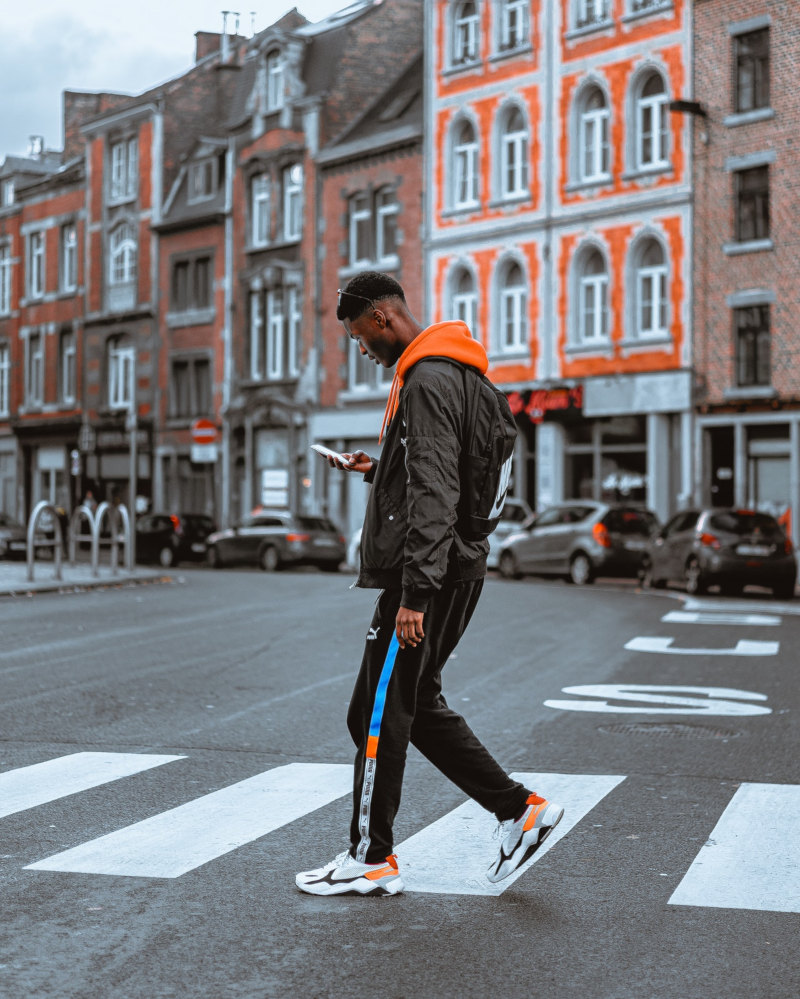

In [14]:
imagem

In [15]:
img = transform(imagem).unsqueeze(0)

In [16]:
out = model(img)

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [17]:
out

{'pred_boxes': tensor([[[0.6305, 0.2313, 0.4484, 0.2991],
          [0.9308, 0.4818, 0.1372, 0.1334],
          [0.4545, 0.2501, 0.7962, 0.3573],
          [0.2096, 0.2368, 0.4140, 0.4632],
          [0.4362, 0.5391, 0.0427, 0.0680],
          [0.5943, 0.8407, 0.2322, 0.1063],
          [0.9399, 0.4710, 0.1171, 0.0952],
          [0.0159, 0.5511, 0.0309, 0.0366],
          [0.5000, 0.4990, 0.9980, 0.9992],
          [0.6453, 0.5343, 0.0806, 0.0687],
          [0.0997, 0.5383, 0.1534, 0.0925],
          [0.5000, 0.2855, 0.9981, 0.5709],
          [0.9450, 0.3045, 0.0553, 0.1434],
          [0.6494, 0.5693, 0.6735, 0.0806],
          [0.6288, 0.5371, 0.0429, 0.0513],
          [0.4100, 0.4677, 0.0547, 0.0286],
          [0.5652, 0.8170, 0.1909, 0.1367],
          [0.5000, 0.7753, 0.9980, 0.4455],
          [0.6365, 0.2259, 0.6831, 0.4449],
          [0.2227, 0.1929, 0.4440, 0.3835],
          [0.4273, 0.2579, 0.8519, 0.5149],
          [0.3487, 0.5427, 0.1777, 0.0646],
          [0.6880,

In [22]:
scores = out['pred_logits'].softmax(-1)[...,:-1].max(-1)[0]

In [23]:
scores

tensor([[8.2859e-03, 7.4256e-03, 1.4789e-02, 9.7865e-03, 4.3259e-03, 7.2785e-02,
         2.8879e-01, 5.2666e-02, 7.0957e-03, 7.8340e-02, 3.1240e-01, 9.8967e-01,
         1.0119e-02, 3.9505e-03, 5.0175e-03, 2.7846e-03, 9.1823e-03, 9.9463e-01,
         1.6767e-02, 4.8658e-02, 1.2402e-02, 9.9965e-01, 9.3247e-04, 1.7974e-02,
         7.0844e-03, 1.1541e-02, 1.1718e-02, 4.0276e-02, 1.8728e-02, 1.0159e-02,
         9.3775e-01, 5.7768e-02, 5.8851e-02, 4.6851e-03, 1.1246e-01, 8.7422e-03,
         1.5325e-02, 1.7662e-02, 2.9340e-03, 4.5971e-03, 2.7135e-03, 1.0091e-02,
         1.3783e-02, 9.9923e-01, 7.2012e-03, 3.7745e-02, 5.9039e-03, 5.1848e-03,
         5.3131e-03, 4.8312e-02, 3.2753e-01, 5.1825e-02, 3.8687e-03, 4.9463e-01,
         1.3370e-02, 1.8437e-02, 1.4355e-01, 2.0807e-02, 1.3366e-02, 2.2595e-02,
         1.1903e-01, 4.8927e-03, 1.6617e-02, 3.4608e-02, 6.0227e-02, 3.5321e-02,
         9.5791e-02, 1.1992e-02, 6.5693e-03, 9.8468e-01, 1.8256e-02, 1.5173e-02,
         1.4436e-02, 4.0708e

In [24]:
keep = scores > 0.85 # Filtro para as melhores previsões

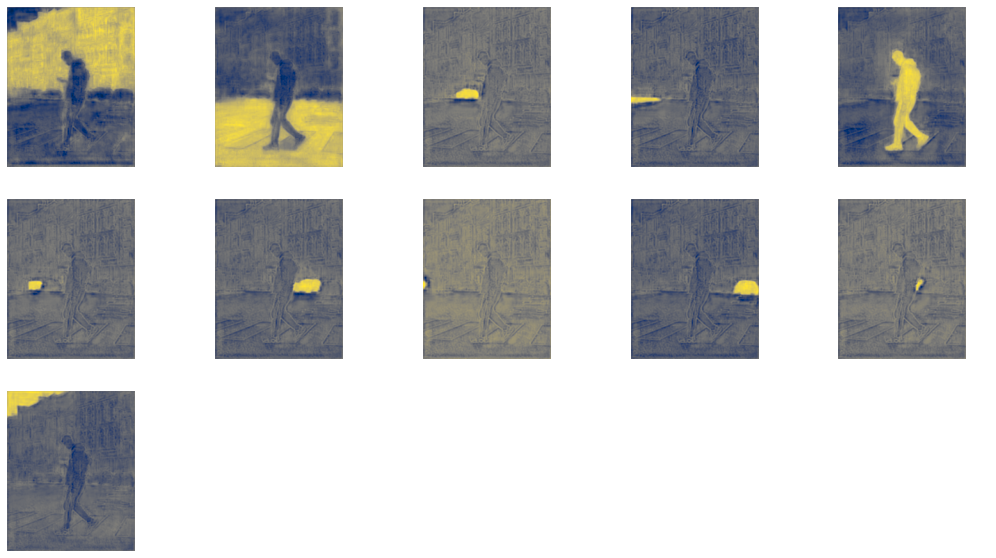

In [27]:
n_colunas = 5
fig, axs = plt.subplots(ncols = n_colunas, nrows = math.ceil(keep.sum().item() / n_colunas), figsize = (18,10))
for line in axs:
  for a in line:
    a.axis('off')

for i, mask in enumerate(out['pred_masks'][keep]):
  ax = axs[i // n_colunas, i % n_colunas]
  ax.imshow(mask, cmap='cividis')
  ax.axis('off')

In [28]:
resultado = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

In [29]:
import itertools
import seaborn as sns

palette = itertools.cycle(sns.color_palette())

In [31]:
seg_panoptica = Image.open(io.BytesIO(resultado['png_string']))
seg_panoptica = numpy.array(seg_panoptica, dtype = numpy.uint8).copy()

In [33]:
seg_panoptica_id = rgb2id(seg_panoptica) # Contém o id ao qual o pixel pertence

(-0.5, 799.5, 998.5, -0.5)

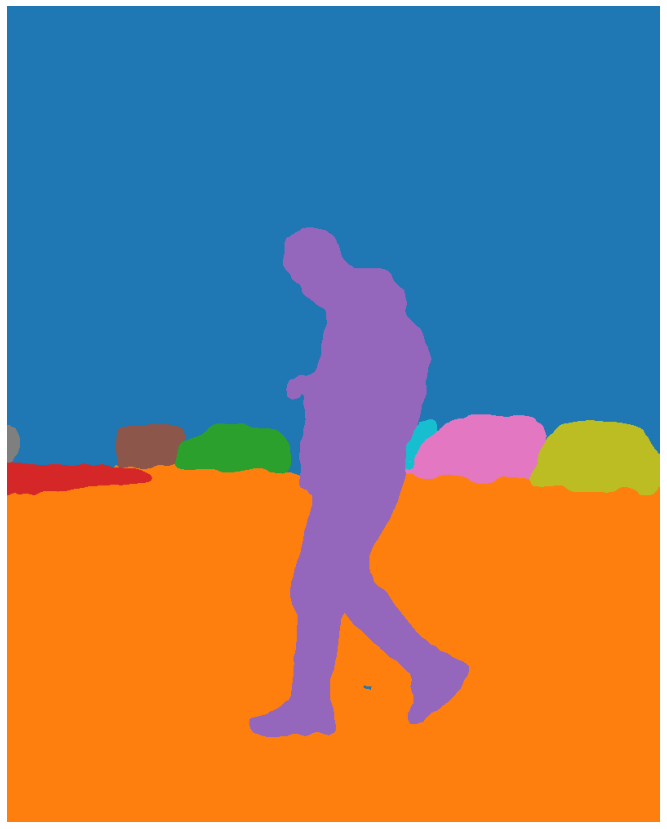

In [35]:
seg_panoptica[:,:,:] = 0

for id in range(seg_panoptica_id.max() + 1):
  seg_panoptica[seg_panoptica_id == id] = numpy.asarray(next(palette)) * 255

plt.figure(figsize = (15,15))
plt.imshow(seg_panoptica)
plt.axis('off')

In [36]:
info_segmentos = deepcopy(resultado['segments_info'])

In [37]:
seg_panoptica = Image.open(io.BytesIO(resultado['png_string']))

In [38]:
final_w, final_h = seg_panoptica.size

In [39]:
seg_panoptica = numpy.asarray(seg_panoptica, dtype = numpy.uint8)
seg_panoptica = torch.from_numpy(rgb2id(seg_panoptica))

In [41]:
meta = MetadataCatalog.get('coco_2017_val_panoptic_separated')

In [42]:
for i in range(len(info_segmentos)):
  c = info_segmentos[i]['category_id']
  info_segmentos[i]['category_id'] = meta.thing_dataset_id_to_contiguous_id[c] if info_segmentos[i]['isthing'] else meta.stuff_dataset_id_to_contiguous_id[c] 

In [43]:
info_segmentos

[{'area': 362769, 'category_id': 50, 'id': 0, 'isthing': False},
 {'area': 299616, 'category_id': 21, 'id': 1, 'isthing': False},
 {'area': 6824, 'category_id': 2, 'id': 2, 'isthing': True},
 {'area': 4936, 'category_id': 44, 'id': 3, 'isthing': False},
 {'area': 71554, 'category_id': 0, 'id': 4, 'isthing': True},
 {'area': 3952, 'category_id': 2, 'id': 5, 'isthing': True},
 {'area': 10687, 'category_id': 2, 'id': 6, 'isthing': True},
 {'area': 578, 'category_id': 2, 'id': 7, 'isthing': True},
 {'area': 11542, 'category_id': 2, 'id': 8, 'isthing': True},
 {'area': 1057, 'category_id': 2, 'id': 9, 'isthing': True},
 {'area': 25685, 'category_id': 40, 'id': 10, 'isthing': False}]

In [44]:
cores_classes = meta.stuff_colors

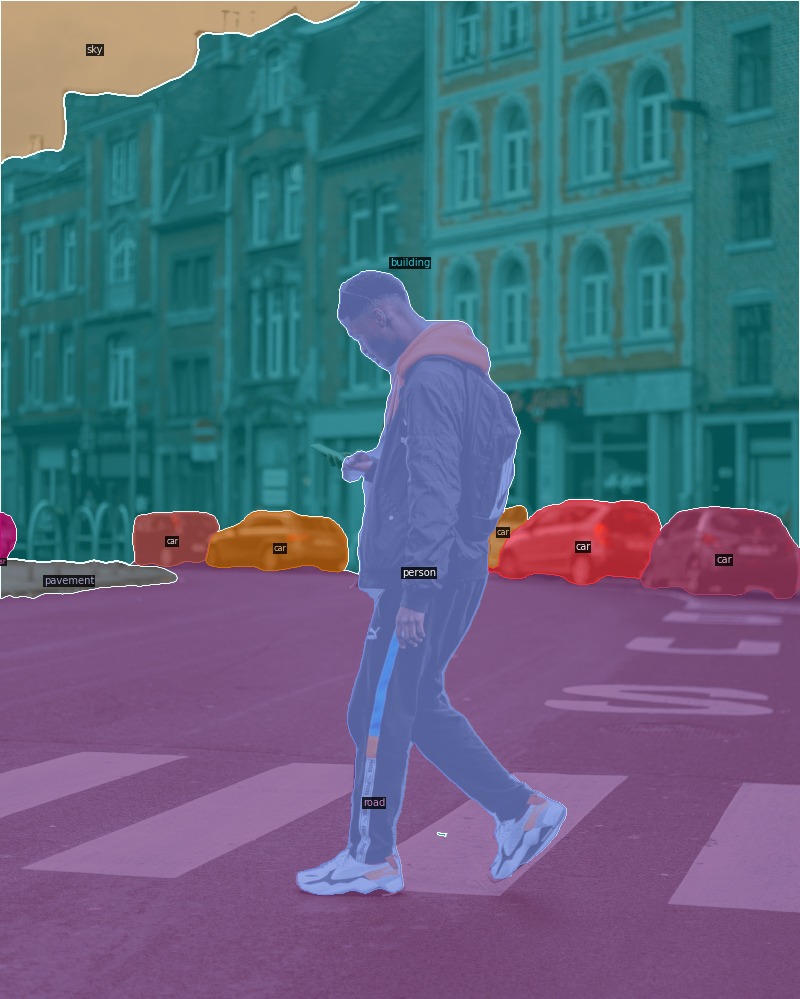

In [46]:
v = Visualizer(numpy.array(imagem.copy().resize((final_w, final_h)))[:,:,::-1], meta, scale = 1.0)
v = v.draw_panoptic_seg_predictions(seg_panoptica, info_segmentos)
resultado_final = v.get_image()
cv2_imshow(resultado_final)